# Embeddings
- [gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_annoy.html?highlight=load%20word2vec%20txt#work-with-google-s-word2vec-files) - **why do I need it????**
- [tokenizer](https://github.com/google/sentencepiece/blob/master/python/README.md)


## Load data (separate dataset)
- the 2008-2016 dataset 
- python language

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks 
from tensorflow.keras import optimizers, models

import sentencepiece as spm

In [2]:
!pip --version

pip 21.0.1 from /Users/alinabogdanova/.pyenv/versions/3.7.10/lib/python3.7/site-packages/pip (python 3.7)


In [3]:
# df = pd.read_csv("python_solved.csv")
df = pd.read_csv("py_df.csv")
df = df.drop(columns=["round", "task", "solution", "file", "full_path", "Unnamed: 0.1", "Unnamed: 0", "lang"])

- Let's remove the sort files, then select users with the highest amount of files

- count lines

In [4]:
df["n_lines"] = df.flines.apply(lambda x: str(x).count("\n"))
df["n_lines"].describe()

count    155359.000000
mean         50.815852
std          70.495160
min           0.000000
25%          27.000000
50%          41.000000
75%          62.000000
max       10052.000000
Name: n_lines, dtype: float64

- let's save files with amount of lines in range `[30; 120]`

In [5]:
df = df[(df.n_lines>0)]#&(df.n_lines<=120)]
df.n_lines.describe()

count    155330.000000
mean         50.825340
std          70.498321
min           1.000000
25%          27.000000
50%          41.000000
75%          62.000000
max       10052.000000
Name: n_lines, dtype: float64

- let's find avg file length (in chars)

In [6]:
# df["n_chars"] = df.flines.apply(lambda x: len(str(x)))
# (df.n_chars/df.n_lines).describe()

- suspicious max value let's drop evetyrhing, highter then `100` and look, what's left

In [7]:
# df["chars_per_line"] = df.n_chars/df.n_lines
# df = df[df.chars_per_line<100]
# df.describe()

- less, then 100 files were removed

## Tokenization
- let's apply embedding to all the source files **LOSE LAYOUT FEATURES**
- * it takes time

Example of lib usage
```python
sp.encode('\tarr = [int(x) for x in str.split()]')
>> [6682, 14, 127, 184, 96091, 96097, 96090, 115, 419, 57, 420, 96084, 1300, 5382]
print(sp.decode(sp.encode('    arr = [int(x) for x in str.split()]')))
>> arr = [int(x) for x in str.split()]
```

In [8]:
sp = spm.SentencePieceProcessor(model_file='embd/sentencepiece_bpe.model')
df.index = np.arange(len(df))
df["n_tokens"] = df.flines.apply(lambda x: len(sp.encode(x)))
df.describe()

,year,n_lines,n_tokens
count,155330.000000,155330.000000,155330.000000
mean,2013.619855,50.825340,343.410333
std,2.254751,70.498321,664.640139
min,2008.000000,1.000000,0.000000
25%,2012.000000,27.000000,172.000000
50%,2014.000000,41.000000,258.000000
75%,2016.000000,62.000000,396.000000
max,2016.000000,10052.000000,36488.000000


- let's set the threshold of 600 tokens here

In [9]:
df = df[df.n_tokens<=600]
df.describe()

,year,n_lines,n_tokens
count,140599.000000,140599.000000,140599.000000
mean,2013.656477,41.831357,264.747061
std,2.242584,21.308814,126.812730
min,2008.000000,1.000000,0.000000
25%,2012.000000,25.000000,165.000000
50%,2014.000000,38.000000,240.000000
75%,2016.000000,55.000000,346.000000
max,2016.000000,380.000000,600.000000


- let's look at the amount of files per participant

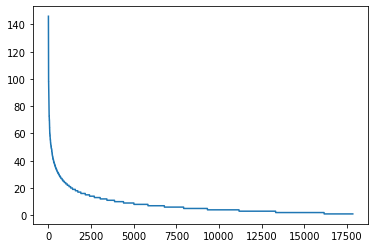

In [10]:
plt.plot(np.array(df.username.value_counts()))

- Let's collect `15` users with avg amount of files, which is around 35
(enough files, but their difference amount is not sufficient)

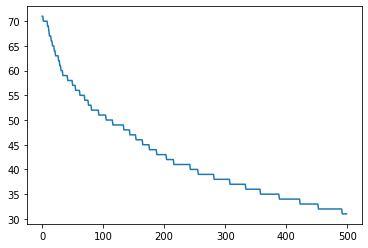

In [11]:
plt.plot(np.array(df.username.value_counts())[50:550])

In [12]:
users = df.username.value_counts()[50:550].index
df = df[df.username.isin(users)]
df.head()

,year,username,flines,n_lines,n_tokens
11,2008,Keegan,#!/usr/bin/env python\n \n import sys\n \n rea...,35,191
49,2008,Klinck,import sys\n import math\n \n cnt = [0]*1024\n...,57,321
50,2008,ipknHama,"n = input()\n for loop in range(1, n+1):\n \t\...",43,321
51,2008,ipknHama,import psyco\n def main():\n \tbcd = {}\n \tde...,63,333
58,2008,Klinck,import sys\n input = sys.stdin\n \n def solve(...,40,313


- Let's look at the amount of files per person in more details

In [13]:
df.username.value_counts().describe()

count    500.000000
mean      42.796000
std        9.693622
min       31.000000
25%       35.000000
50%       40.000000
75%       49.000000
max       71.000000
Name: username, dtype: float64

- Hope, this is enough and the contrast between the smallest amount and the max, won't be sufficient

In [14]:
df.username.value_counts()

sekiye         71
archangel11    71
shacharr       70
pawko          70
killerrex      70
               ..
lookingfor     31
zepp           31
jtidor         31
sandeva        31
shomster       31
Name: username, Length: 500, dtype: int64

In [15]:
df["tokens"] = df.flines.apply(lambda x: sp.encode(x))

In [16]:
df.head()

,year,username,flines,n_lines,n_tokens,tokens
11,2008,Keegan,#!/usr/bin/env python\n \n import sys\n \n rea...,35,191,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
49,2008,Klinck,import sys\n import math\n \n cnt = [0]*1024\n...,57,321,"[138, 1149, 138, 5045, 17170, 14, 64737, 18033..."
50,2008,ipknHama,"n = input()\n for loop in range(1, n+1):\n \t\...",43,321,"[49, 14, 1128, 101, 115, 3737, 57, 1181, 2480,..."
51,2008,ipknHama,import psyco\n def main():\n \tbcd = {}\n \tde...,63,333,"[138, 20653, 62, 63, 2536, 586, 67, 3382, 14, ..."
58,2008,Klinck,import sys\n input = sys.stdin\n \n def solve(...,40,313,"[138, 1149, 1128, 14, 1149, 96084, 8827, 63, 1..."


In [17]:
dataset = df[["username", "tokens"]]

In [18]:
dataset

,username,tokens
11,Keegan,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
49,Klinck,"[138, 1149, 138, 5045, 17170, 14, 64737, 18033..."
50,ipknHama,"[49, 14, 1128, 101, 115, 3737, 57, 1181, 2480,..."
51,ipknHama,"[138, 20653, 62, 63, 2536, 586, 67, 3382, 14, ..."
58,Klinck,"[138, 1149, 1128, 14, 1149, 96084, 8827, 63, 1..."
...,...,...
155325,Fantoccini,"[156, 12330, 138, 15913, 156, 4159, 138, 8485,..."
155326,Fantoccini,"[156, 12330, 138, 15913, 156, 4159, 138, 8485,..."
155327,Fantoccini,"[156, 12330, 138, 15913, 63, 13778, 96091, 960..."
155328,Fantoccini,"[156, 12330, 138, 15913, 63, 13778, 96091, 960..."


## Load data
Lib selected - tensorflow + keras

### Some small notes for future
Tensorflow supports python 3.8 as max version. The issue arises on latest Ubuntu/max os-es, when the default python version is 3.9.

What was done on MAC-OS-Big-Sur to solve that issue.
- [pyenv](https://github.com/pyenv/pyenv) installed
```bash
>> brew update
>> brew install pyenv
...
```
- python 3.7 installation
```
>> brew install python@3.7
```
- pyenv added python 3.7
```
>> pyenv install 3.7.10
>> pyenv loacal 3.7.10
```
- create [myenv](https://www.tensorflow.org/install/pip#2.-create-a-virtual-environment-recommended)
```
>> python3.7 -m venv myenv
>> source myenv/bin/activate.fish
```
- solution of the final problem - **UPGRADE PIP**
- install tensorflow
```
(myenv)>> pip install --upgrade tensorflow
```

In [19]:
le = LabelEncoder()
dataset.username = le.fit_transform(dataset.username)

/Users/alinabogdanova/Documents/workspace/research/myenv/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [20]:
# shuffle dataset
dataset = dataset.sample(frac = 1) 
dataset

,username,tokens
101527,201,"[8444, 96117, 14, 2705, 96102, 63, 13778, 9609..."
149513,415,"[46, 1386, 1867, 96093, 2043, 1109, 1386, 138,..."
113825,339,"[63, 13778, 96077, 2292, 96091, 10022, 96077, ..."
90717,43,"[138, 1149, 11791, 14, 1149, 96084, 8827, 63, ..."
69537,490,"[138, 1149, 156, 4159, 138, 19453, 29, 14, 138..."
...,...,...
87132,10,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
145517,275,"[63, 9158, 96091, 96151, 96085, 1385, 45, 170,..."
28459,217,"[3238, 2785, 96124, 1119, 96124, 1796, 156, 69..."
21261,63,"[3074, 594, 2785, 96124, 1119, 96124, 1796, 67..."


In [21]:
def rsh(x):
    arr = np.array(x)
    arr.resize(600)
    return list(arr)

dataset.tokens = dataset.tokens.apply(rsh)

In [22]:
dataset

,username,tokens
101527,201,"[8444, 96117, 14, 2705, 96102, 63, 13778, 9609..."
149513,415,"[46, 1386, 1867, 96093, 2043, 1109, 1386, 138,..."
113825,339,"[63, 13778, 96077, 2292, 96091, 10022, 96077, ..."
90717,43,"[138, 1149, 11791, 14, 1149, 96084, 8827, 63, ..."
69537,490,"[138, 1149, 156, 4159, 138, 19453, 29, 14, 138..."
...,...,...
87132,10,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
145517,275,"[63, 9158, 96091, 96151, 96085, 1385, 45, 170,..."
28459,217,"[3238, 2785, 96124, 1119, 96124, 1796, 156, 69..."
21261,63,"[3074, 594, 2785, 96124, 1119, 96124, 1796, 67..."


In [23]:
dataset.to_json("train.json")

In [4]:
dataset = pd.read_json("train.json")

In [5]:
X = dataset.tokens.values
X = np.array(list(X))
X.shape

(21398, 600)

In [6]:
X = X.reshape((-1, 600, 1))
y = np.array(dataset.username)

ohe = OneHotEncoder()
y = ohe.fit_transform(y.reshape(-1, 1))
y = y.toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(16048, 600, 1)

### Structure of the model
1. CNN:
- ks = 50 (function - level)
- ks = 10 (line2 - level)
- ks = 5 (lene - level)
2. Linear ReLU 
3. softmax 75

> important note `tanh` activation increases accuracy from 11% to 60% ontraining (50% of test accuracy)
>
> `linear` function reaches up to 61% of test accuracy

In [7]:
X = X[np.where(np.argmax(y, axis=1) < 40)]
y = y[np.where(np.argmax(y, axis=1) < 40)]
ohe = OneHotEncoder()
y = ohe.fit_transform(np.argmax(y, axis = 1).reshape(-1, 1)).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
model = keras.Sequential()
model.add(keras.Input(shape=(600, 1)))  
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(40, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 591, 150)          1650      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 73, 150)           0         
_________________________________________________________________
flatten (Flatten)            (None, 10950)             0         
_________________________________________________________________
dropout (Dropout)            (None, 10950)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                700864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2

In [30]:
optimizer = optimizers.Adam(0.1)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_delta=0.000001, verbouse=1)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [31]:
epochs = 150
batch_size = 20
history = model.fit(x=X_train, y=y_train, epochs = epochs, 
                    validation_data = (X_test,y_test),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=2, 
                    callbacks=[lr_schedule])

Epoch 1/150
63/63 - 2s - loss: 20086350.0000 - accuracy: 0.0455 - val_loss: 25771066.0000 - val_accuracy: 0.0796
Epoch 2/150
63/63 - 1s - loss: 53394520.0000 - accuracy: 0.0568 - val_loss: 46603112.0000 - val_accuracy: 0.0913
Epoch 3/150
63/63 - 1s - loss: 99113384.0000 - accuracy: 0.0697 - val_loss: 94409760.0000 - val_accuracy: 0.0632
Epoch 4/150
63/63 - 1s - loss: 139661248.0000 - accuracy: 0.0689 - val_loss: 86394472.0000 - val_accuracy: 0.1030
Epoch 5/150
63/63 - 1s - loss: 165303312.0000 - accuracy: 0.0856 - val_loss: 118794112.0000 - val_accuracy: 0.1054
Epoch 6/150
63/63 - 1s - loss: 185155472.0000 - accuracy: 0.0977 - val_loss: 126833760.0000 - val_accuracy: 0.0960
Epoch 7/150
63/63 - 1s - loss: 177190368.0000 - accuracy: 0.1015 - val_loss: 113504144.0000 - val_accuracy: 0.1639
Epoch 8/150
63/63 - 1s - loss: 182382448.0000 - accuracy: 0.1159 - val_loss: 99374896.0000 - val_accuracy: 0.1733
Epoch 9/150
63/63 - 1s - loss: 172262608.0000 - accuracy: 0.1409 - val_loss: 102670064.0

In [32]:
def plot_training(history):
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.title("Loss")
    plt.plot(history.history['loss'], color='b', label="Training loss")
    plt.plot(history.history['val_loss'], color='r', label="validation loss")
    plt.legend(loc='best', shadow=True)

    plt.subplot(122)
    plt.title("Accuracy")
    plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.legend(loc='best', shadow=True)
    return fig

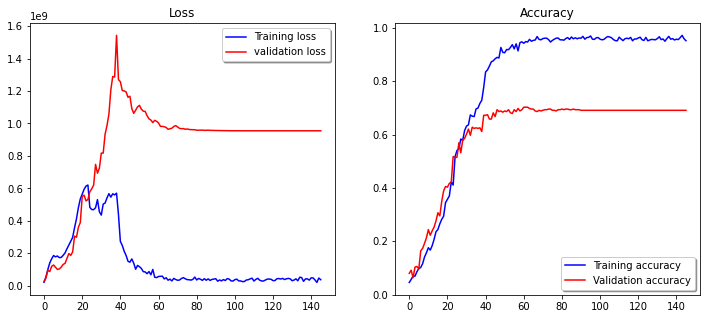

In [33]:
f = plot_training(history)

#### 64% test accuracy

```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 32, activation="linear"))
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### up to 76% test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 16, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### converges to 76% test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 8, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 77% of test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1))) 
model.add(layers.Conv1D(150, 8, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=6))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### confident 81%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(128, 16, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### up to 81.71%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1))) 
model.add(layers.Conv1D(128, 16, activation="linear", strides=2)) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### converges to 80%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

- Also the structures with 2 Convolutional layers were tested (up to 50% accuracy)
- Avg Pooling works poarly due to the fact, that the initial data is not normalized

In [34]:
from sklearn.metrics import confusion_matrix
import itertools

def plt_conf_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
     

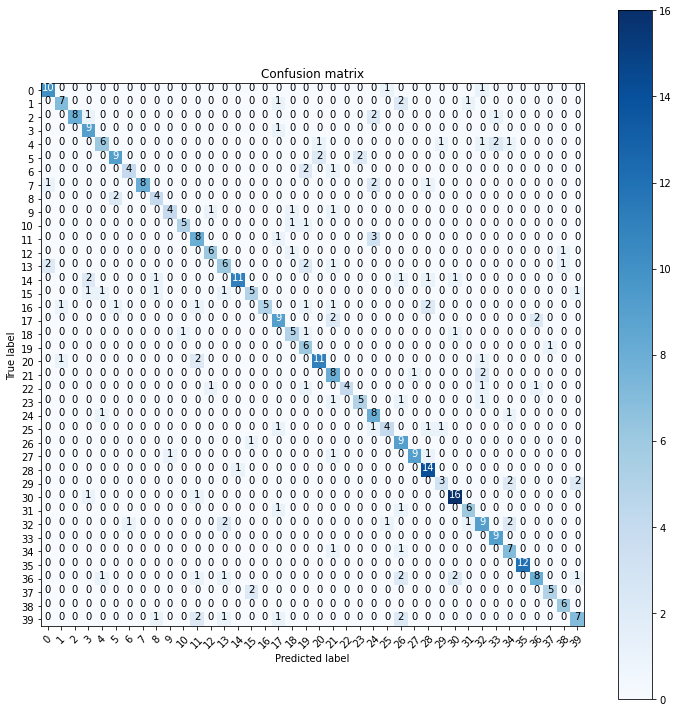

In [35]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plt_conf_matrix(confusion_mtx, classes = range(40))

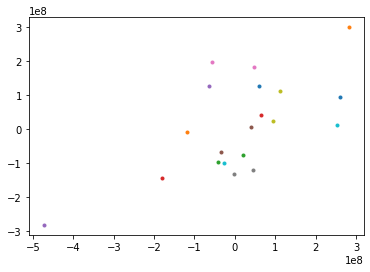

In [36]:
# visualize the embedding
from sklearn.decomposition import PCA
pca = PCA(2)


embd_model = keras.Sequential()
embd_model.add(keras.Input(shape=(600, 1)))  
embd_model.add(layers.Conv1D(150, 10, activation="linear")) 
embd_model.add(layers.MaxPooling1D(pool_size=8))
embd_model.add(layers.Flatten())
embd_model.add(layers.Dense(64, activation="linear"))
embd_model.layers[0].set_weights([model.layers[0].get_weights()[0], model.layers[0].get_weights()[1]])
embd_model.layers[3].set_weights([model.layers[4].get_weights()[0], model.layers[4].get_weights()[1]])

embd_train = embd_model.predict(X_train)

components = pca.fit_transform(embd_train)

for developer in range(10, 20):
    index = np.where(np.argmax(y_train, axis=1)==developer)
    plt.plot(components[index][0], components[index][1], 'o', ms=3)

In [37]:
## they are not close

In [38]:
model.save('model.h5')

I don't know, what are these ebbeddings, but...

## Let's apply normalization
(thus `relu`, `than` and other activations may be used)

In [9]:
print(X.min(), X.mean(), X.max())

0.0 11879.594527629233 96161.0


As it can be seen, the avg value is far from it's maximum value, thus it is more readonable to apply Standard Scaling

In [10]:
ss = StandardScaler()

ss.fit(X_train.reshape((-1, 600)))
def scale(X):
    X = X.reshape((-1, 600))
    X = ss.transform(X)
    X = X.reshape((-1, 600, 1))
    return X

X_train = scale(X_train)
X_test = scale(X_test)


In [42]:
model = keras.Sequential()
model.add(keras.Input(shape=(600, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(40, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 585, 64)           1088      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 73, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 70, 32)            8224      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)              

In [43]:
optimizer = optimizers.Adam(0.01)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_delta=0.000001, verbouse=1)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [44]:
epochs = 200
batch_size = 20
history = model.fit(x=X_train, y=y_train, epochs = epochs, 
                    validation_data = (X_test,y_test),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=2, 
                    callbacks=[lr_schedule])

Epoch 1/200
63/63 - 1s - loss: 4.0147 - accuracy: 0.0371 - val_loss: 3.6547 - val_accuracy: 0.0422
Epoch 2/200
63/63 - 1s - loss: 3.9251 - accuracy: 0.0439 - val_loss: 3.5594 - val_accuracy: 0.0820
Epoch 3/200
63/63 - 1s - loss: 3.9503 - accuracy: 0.0576 - val_loss: 3.5899 - val_accuracy: 0.0632
Epoch 4/200
63/63 - 1s - loss: 3.8999 - accuracy: 0.0727 - val_loss: 3.4943 - val_accuracy: 0.0656
Epoch 5/200
63/63 - 1s - loss: 4.0058 - accuracy: 0.0621 - val_loss: 3.5821 - val_accuracy: 0.0749
Epoch 6/200
63/63 - 1s - loss: 4.0133 - accuracy: 0.0636 - val_loss: 3.5282 - val_accuracy: 0.1148
Epoch 7/200
63/63 - 1s - loss: 4.0605 - accuracy: 0.0712 - val_loss: 3.5236 - val_accuracy: 0.1007
Epoch 8/200
63/63 - 1s - loss: 4.1423 - accuracy: 0.0689 - val_loss: 3.6493 - val_accuracy: 0.0585
Epoch 9/200
63/63 - 1s - loss: 4.2583 - accuracy: 0.0568 - val_loss: 3.5589 - val_accuracy: 0.0890
Epoch 10/200
63/63 - 1s - loss: 4.2193 - accuracy: 0.0614 - val_loss: 3.5812 - val_accuracy: 0.0913
Epoch 11/

#### 80% accuracy (previous model)
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 82%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(128, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 86% up to 87%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 84%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```
#### 84%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.AveragePooling1D(pool_size=8))
model.add(layers.Conv1D(32, 8, activation="linear")) 
model.add(layers.AveragePooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 83%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(128, 16, activation="relu"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

In [45]:
model.save('86_model.h5')

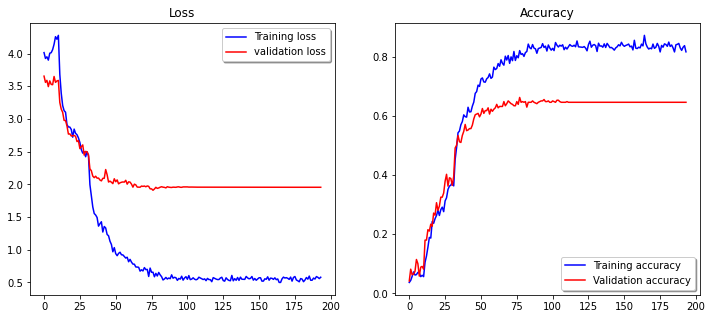

In [46]:
f = plot_training(history)

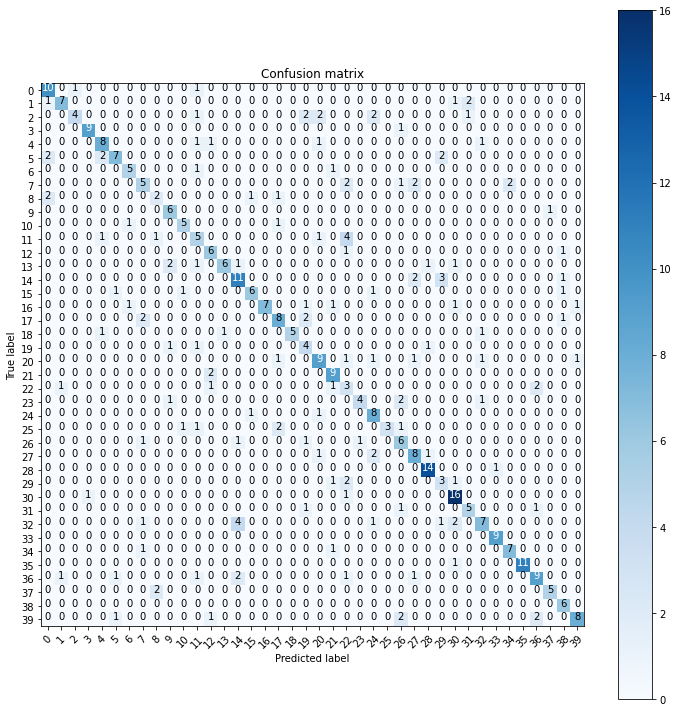

In [47]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plt_conf_matrix(confusion_mtx, classes = range(40))

In [48]:
# visualize the embedding
from sklearn.decomposition import PCA
pca = PCA(2)

embd_model = keras.Sequential()
embd_model.add(keras.Input(shape=(600, 1)))
embd_model.add(layers.Conv1D(64, 16, activation="tanh"))
embd_model.add(layers.MaxPooling1D(pool_size=8))
embd_model.add(layers.Conv1D(32, 4, activation="linear")) 
embd_model.add(layers.MaxPooling1D(pool_size=8))
embd_model.add(layers.Flatten())
embd_model.add(layers.Dense(100, activation="linear"))

embd_model.layers[0].set_weights([model.layers[0].get_weights()[0], model.layers[0].get_weights()[1]])
embd_model.layers[2].set_weights([model.layers[2].get_weights()[0], model.layers[2].get_weights()[1]])
embd_model.layers[5].set_weights([model.layers[6].get_weights()[0], model.layers[6].get_weights()[1]])

embd_train = embd_model.predict(X_train)

components = pca.fit_transform(embd_train)

In [49]:
X_train.shape

(1278, 600, 1)

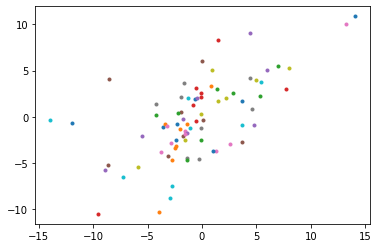

In [50]:
for developer in range(0, 40):
    index = np.where(np.argmax(y_train, axis=1)==developer)
    plt.plot(components[index][0], components[index][1], 'o', ms=3)

## Triplet loss
- useful [link1](https://zhangruochi.com/Create-a-Siamese-Network-with-Triplet-Loss-in-Keras/2020/08/11/ ), [link2](https://codepad.co/snippet/triplet-loss-in-keras-tensorflow-backend)

### Main idea (If I understood correctly)
- create embedding for embeddings (?)
- apply KNN to find the closest vectors - if the problem is related to the classification

### Data preprocessing flow:
1. Split X[-1, 500] on pices of [-1, 100] and increase the dimensionality of array
2. Shuffle ???
3. Create batch_loader:
        3.1. Select anchor samples (**TODO** search if it is usually done sequentially or randomly)
        3.2. Select some X, where y is the same (random or sequential???)
        3.3. Select some X, where y is different (random or sequential???)
4. Create model (e.g. Sequential)
5. Concatenate 3 models for anchor, positives an negatives // this is exactly the parallel convolution, which I was searching during the previous stages
6. Create a functions `loss` and `data_generator`
7. Train model with dummy y (e.g 0) ([good example](https://github.com/AdrianUng/keras-triplet-loss-mnist#visualizing-separation-of-classes ), [their code](https://github.com/AdrianUng/keras-triplet-loss-mnist/blob/master/Triplet_loss_KERAS_semi_hard_from_TF.ipynb))
8. Apply the visualization with PCA/test on KNN????

### Make samples smaller, e.g. 100
- potential problem - files are ended with zeros, if amount of tokens is less


In [11]:
import tensorflow_addons as tfa

In [61]:
X = dataset.tokens.values
X = np.array(list(X))
X = X.reshape((-1, 600, 1))

y = np.array(dataset.username)

ohe = OneHotEncoder()
y = ohe.fit_transform(y.reshape(-1, 1))
y = y.toarray()

X_new, X_test, y_new, y_test = train_test_split(X, y)
X_new.shape

(16048, 600, 1)

In [62]:
ss = StandardScaler()
ss.fit(X_new.reshape(-1, 600))
X_new = ss.transform(X_new.reshape((-1, 600))).reshape((-1, 600, 1))
X_test = ss.transform(X_test.reshape((-1, 600))).reshape((-1, 600, 1))

In [63]:
def crop_to(X, y, crop=100, threshold=80):
    new_X = []
    new_y = []
    for old_x, old_y in zip(X, y):
        for el in old_x.reshape(-1, crop):
            if(np.count_nonzero(el) > 80):
                new_X.append(list(el))
                new_y.append(np.argmax(old_y))
    
    new_X = np.array(new_X).reshape(-1, crop, 1)
    new_y = np.array(new_y)
    return new_X, new_y

# new_X, new_y = crop_to(X_new, y_new, 500)
new_X, new_y = X_new, y_new

In [64]:
new_X.shape

(16048, 600, 1)

In [65]:
data_length = new_y.shape[0]

### Shuffle - do I need this?
- No, because in the batch I'm going to use random

### Batch generation

In [18]:
def batch_generator(X, y):
    
    data_length = X.shape[0]
    index = np.random.randint(data_length)
    anchor, anchor_y = X[index], y[index]
    
    positive = X[np.random.choice(np.where(y==anchor_y)[0])]
    negative = X[np.random.choice(np.where(y!=anchor_y)[0])]
    
    return [list(anchor), list(positive), list(negative)]

def batches_generator(X, y, batch_size=32):
    '''
    Array of batch_generator results
    
    batch_size - size of the generated array
    '''
    all_data = np.array([batch_generator(X, y) for i in range(batch_size)])
    anchors = all_data[:, 0, :]
    positives = all_data[:, 1, :]
    negatives = all_data[:, 2, :]
    return anchors, positives, negatives

def data_generator(X, y, batch_size=32, input_size=600):
    while True:
        batch = batches_generator(X, y, batch_size)
        labels = np.zeros((batch_size, input_size*3)) 
        yield batch, labels
        


### Model creation


- let's repeat the best arch

In [19]:
import tensorflow as tf
from tensorflow.keras import regularizers


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [20]:
params = {
    "activations" : ["tanh", "relu", "elu", "sigmoid", "linear", "selu", "gelu", "swish"],
    #"output_sizes" : [50, 100, 500],
    "L2_lambda": [0.01, 0.001, 0.0001],
    "pool_1_size": [4, 8],
    "pool_2_size":[4, 8],
    "conv_1_size": [16, 32, 64],
    "conv_2_size":[4, 8],
    "dense_1": [64]   
}
params = {
    "activations" : ["relu"],
    #"output_sizes" : [50, 100, 500],
    "L2_lambda": [0.001],
    "pool_1_size": [4, 8],
    "pool_2_size":[4, 8],
    "conv_1_size": [8, 16],
    "conv_2_size":[4, 8],
    "dense_1": [64]   
}

In [21]:
new_X.shape, new_y.shape

((16048, 600, 1), (16048, 500))

In [22]:
output_size = 50
input_size = 600

In [23]:
def create_model(activation="linear", L2_lambda=0.02, 
                 pool_1_size=4, pool_2_size=4, 
                 conv_1_size=16, conv_2_size=4, dense_1=64):
    
    model_core = keras.Sequential()
    model_core.add(layers.Conv1D(64, conv_1_size, 
                                 activation=activation, 
                                 kernel_regularizer=regularizers.L2(L2_lambda)))
    
    model_core.add(layers.LayerNormalization(axis=1))
    model_core.add(layers.MaxPooling1D(pool_size=pool_1_size))
    
    model_core.add(layers.Conv1D(32, conv_2_size, 
                                 activation=activation, 
                                 kernel_regularizer=regularizers.L2(L2_lambda)))

    model_core.add(layers.LayerNormalization(axis=1))
    model_core.add(layers.MaxPooling1D(pool_size=pool_2_size))
    
    model_core.add(layers.Flatten())
    model_core.add(layers.Dropout(0.5))
    model_core.add(layers.Dense(dense_1, activation=activation, 
                                kernel_regularizer=regularizers.L2(L2_lambda)))
    model_core.add(layers.LayerNormalization(axis=1))
    
    model_core.add(layers.Dropout(0.5))
    model_core.add(layers.Dense(output_size, activation=activation, 
                                kernel_regularizer=regularizers.L2(L2_lambda)))
    model_core.add(layers.LayerNormalization(axis=1))
    return model_core


In [24]:
def triplet_loss(y_true, y_pred):
    alpha = 0.2
    y_pred = tf.convert_to_tensor(y_pred)
    global output_size
    anchor = y_pred[:, :output_size]
    positive = y_pred[:, output_size:2*output_size]
    negative = y_pred[:, 2*output_size:]
    
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)

    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [25]:
def create_triplet_model(input_size, model_core):
    
    input_anchor = layers.Input(shape=(input_size, 1))
    input_positive = layers.Input(shape=(input_size, 1))
    input_negative = layers.Input(shape=(input_size, 1))

    model_anchor = model_core(input_anchor)
    model_positive = model_core(input_positive)
    model_negative = model_core(input_negative)

    result = layers.concatenate([model_anchor, model_positive, model_negative], axis=1)
    model = models.Model([input_anchor, input_positive, input_negative], result)
    return model


In [26]:
def train(new_X, new_y, input_size, model):
    batch_size = 64
    epochs = 100
    steps_per_epoch = int(new_X.shape[0]/batch_size)

    optimizer = optimizers.Adam(0.1)
    lr_schedule = callbacks.ReduceLROnPlateau(monitor='loss', actor=0.5, patience=2, min_delta=0.000001, verbouse=1)
    early_stopping = callbacks.EarlyStopping(monitor="loss", min_delta = 0.0001, patience=10, restore_best_weights=True)

    model.compile(loss=triplet_loss, optimizer=optimizer)
    history = model.fit(data_generator(new_X, new_y, batch_size, input_size),
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs, 
                        verbose=1, 
                        callbacks=[lr_schedule, early_stopping])
    return model, history


In [27]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [28]:
def test(model_core, new_X, new_y):
    transformed_X = model_core.predict(new_X.reshape(-1, input_size, 1))
    X_train, X_test, y_train, y_test = train_test_split(transformed_X, new_y)
    
   
    knn = KNeighborsClassifier(n_neighbors=3, algorithm="ball_tree", weights="distance")
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    
    return score

In [29]:
param_list = []
for key in params.keys():
    if len(param_list)==0:
        for x in params[key]:
            param_list.append([x])
    else:
        new_param_list = []
        for l in param_list:
            for x in params[key]:
                l_copy = l.copy()
                l_copy.append(x)
                new_param_list.append(l_copy)
        param_list = new_param_list
len(param_list)

16

In [30]:
param_list[0]

['relu', 0.001, 4, 4, 8, 4, 64]

In [31]:
import tqdm

In [93]:
max_score = 0
best_model = None
log = []
core_model = None
for p in tqdm.tqdm(param_list[3:4]):
    core_model = create_model(*p)
    triplet = create_triplet_model(input_size, core_model)
    model, history = train(new_X, new_y, input_size, triplet)
    score = test(core_model, new_X, new_y)
    if score > max_score:
        max_score = score
        best_model = model
        print(p, score)
    log.append({"score": score, "history": history, "params": p})


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
250/250 [==============================] - 1574s 6s/step - loss: 2.0021
Epoch 2/100
250/250 [==============================] - 1576s 6s/step - loss: 0.3502
Epoch 3/100
250/250 [==============================] - 1570s 6s/step - loss: 0.2103
Epoch 4/100
250/250 [==============================] - 1575s 6s/step - loss: 0.2002
Epoch 5/100
250/250 [==============================] - 1571s 6s/step - loss: 0.2000
Epoch 6/100
250/250 [==============================] - 1576s 6s/step - loss: 0.2000
Epoch 7/100
250/250 [==============================] - 1573s 6s/step - loss: 0.2000
Epoch 8/100
250/250 [==============================] - 1577s 6s/step - loss: 0.2000
Epoch 9/100
250/250 [==============================] - 1579s 6s/step - loss: 0.2000
Epoch 10/100
250/250 [==============================] - 1573s 6s/step - loss: 0.2000
Epoch 11/100
250/250 [==============================] - 1574s 6s/step - loss: 0.2000
Epoch 12/100
250/250 [==============================] - 1579s 6s/step - lo

100%|██████████| 1/1 [6:07:56<00:00, 22076.52s/it]


In [94]:
print(len(log))

1


In [95]:
log_df = pd.DataFrame(log)

In [96]:
log_df

,score,history,params
0,0.0,<tensorflow.python.keras.callbacks.History obj...,"[relu, 0.001, 4, 4, 16, 8, 64]"


In [97]:
log_df["history_arr"] = log_df.history.apply(lambda x: x.history["loss"])

In [98]:
log_df["activations"] = log_df.params.apply(lambda x:x[0])
log_df["L2_lambda"]  = log_df.params.apply(lambda x:x[1])
log_df[ "pool_1_size"] = log_df.params.apply(lambda x:x[2])
log_df[ "pool_2_size"] = log_df.params.apply(lambda x:x[3])
log_df["conv_1_size"] = log_df.params.apply(lambda x:x[4])
log_df["conv_2_size"] = log_df.params.apply(lambda x:x[5])
log_df["dense_1"] = log_df.params.apply(lambda x:x[6])

In [99]:
log_df = log_df.drop(columns=["history", "params"])

In [100]:
log_df.score.describe()

count    1.0
mean     0.0
std      NaN
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: score, dtype: float64

#### All the tame accuracy was approximately the same

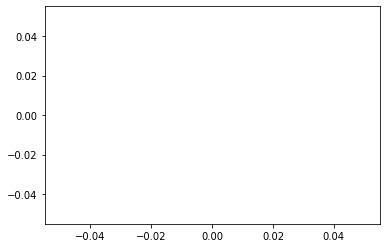

In [101]:
plt.plot(log_df.score)

### How the best model was trained?

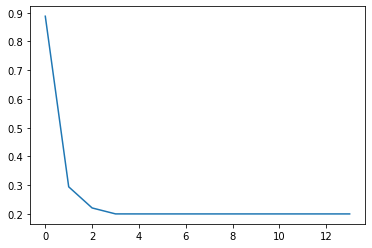

In [102]:
plt.plot(log_df.history_arr[0])

In [103]:
log_df.to_csv("grid_6.csv")

In [136]:
log_df.to_json("grid_6.json")# arrays could be exported better (history)

-  52% - 20-40 by amount of files, 600 input - 100 output
-  53% - 20-40 by amount of files, 600 input - 200 output
-  53% - 20-40 by amount of files, 600 input - 400 output
- 33% - 20-40 by amount of files, 100 input - 100 output
-  49.7% - 0-40 by amount of files, 600 input - 100 output

### Read more
- [implementation by tensorflow](https://www.tensorflow.org/addons/tutorials/losses_triplet)

## What's going on!?
Why the accuracy is so low! Let's look at the PCA of the daataset

In [32]:
import numpy as np
from sklearn.decomposition import PCA

In [105]:
# pass the data through the model

In [106]:
vectorized_X = core_model.predict(new_X)

pca = PCA(n_components=3)

pca.fit(vectorized_X)

pca_x = pca.transform(vectorized_X)

y1d = new_y
# y1d = np.argmax(new_y, axis=1)

pca_x[np.where(y1d==0), 0]

array([[8.165467e-05, 8.165467e-05, 8.165467e-05, ..., 8.165467e-05,
        8.165467e-05, 8.165467e-05],
       [8.165467e-05, 8.165467e-05, 8.165467e-05, ..., 8.165467e-05,
        8.165467e-05, 8.165467e-05]], dtype=float32)

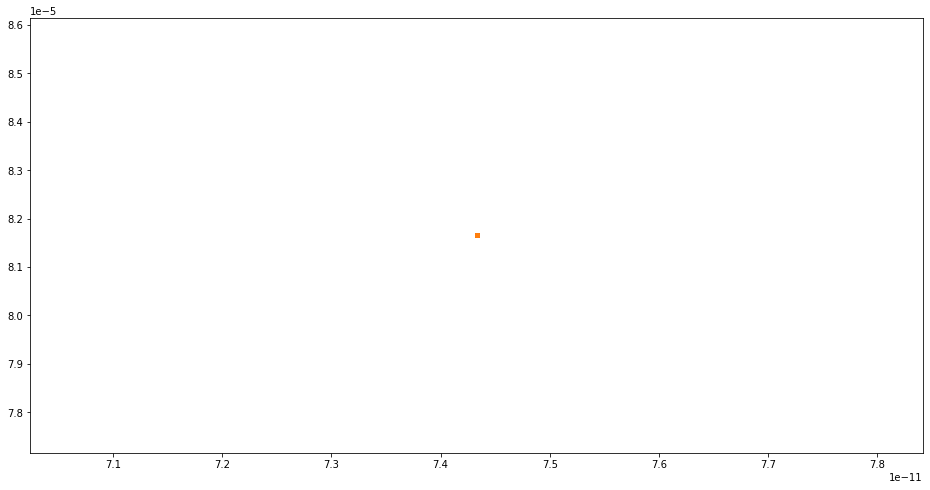

In [108]:
plt.figure(figsize=(16, 8))
for i in range(500):
    plt.plot(pca_x[np.where(y1d==i), 2][0], pca_x[np.where(y1d==i), 0][0], 'o', ms=4)# label=str(i))
# plt.legend(ncol=4)

Before
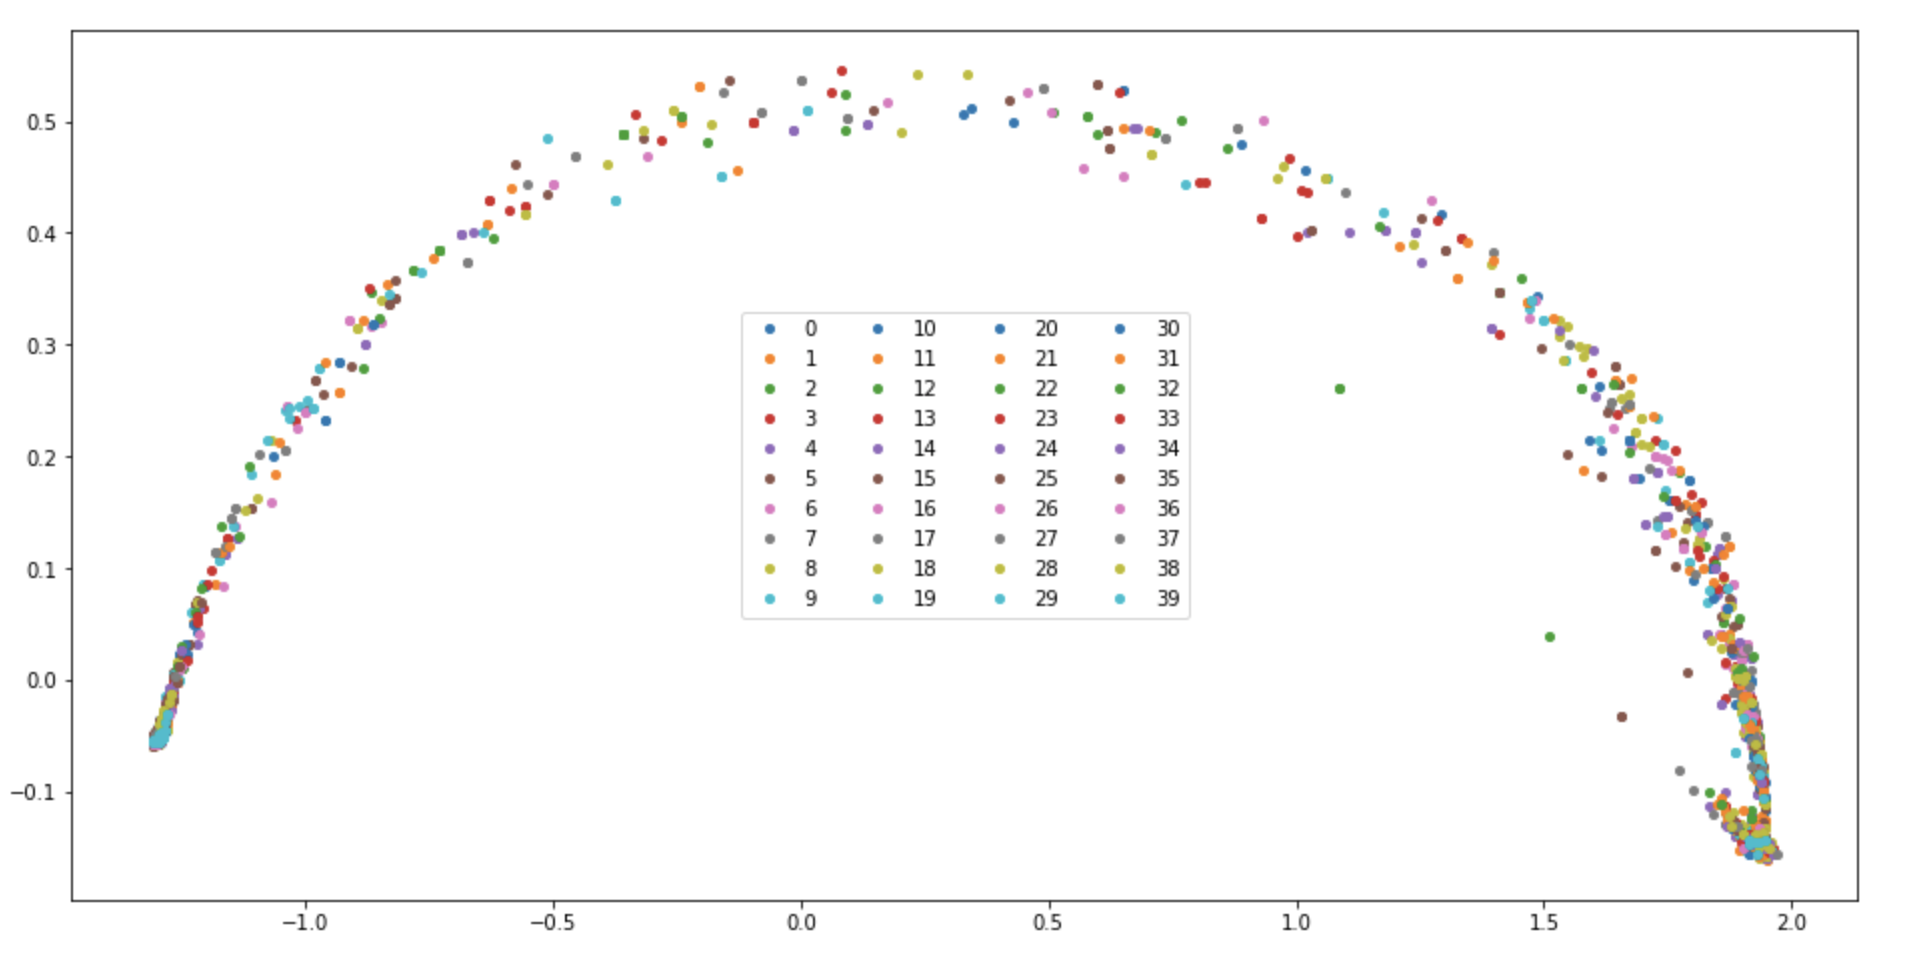

### Ok... Let's train the model on the top of the embeddings

In [143]:
new_y
ohe = OneHotEncoder()
new_y = ohe.fit_transform(new_y.reshape(-1, 1))
new_y = new_y.toarray()

In [144]:
classifier = keras.Sequential()
classifier.add(layers.Input((1, 50)))
classifier.add(layers.Dense(128, activation="linear"))
classifier.add(layers.LayerNormalization(axis=1))
classifier.add(layers.Dropout(0.5))
classifier.add(layers.Dense(64, activation="linear"))
classifier.add(layers.LayerNormalization(axis=1))
classifier.add(layers.Dropout(0.5))
classifier.add(layers.Dense(500, activation="softmax"))

In [145]:
vectorized_X.shape

(21398, 50)

In [146]:
new_y.shape

(21398, 500)

In [147]:
batch_size = 64
epochs = 100
steps_per_epoch = int(vectorized_X.shape[0]/batch_size)

optimizer = optimizers.Adam(0.1)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='loss', actor=0.5, patience=2, min_delta=0.000001, verbouse=1)
early_stopping = callbacks.EarlyStopping(monitor="loss", min_delta = 0.0001, patience=5, restore_best_weights=True)


classifier.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])
history = classifier.fit(x=vectorized_X, y=new_y, epochs = epochs, 
                        validation_data = (vectorized_X,new_y),
                        steps_per_epoch=vectorized_X.shape[0] // batch_size,
                        verbose=2, 
                        callbacks=[lr_schedule, early_stopping])

Epoch 1/100
334/334 - 2s - loss: 6.3403 - accuracy: 0.0022 - val_loss: 6.2758 - val_accuracy: 0.0029
Epoch 2/100
334/334 - 1s - loss: 6.3147 - accuracy: 0.0018 - val_loss: 6.2662 - val_accuracy: 0.0030
Epoch 3/100
334/334 - 1s - loss: 6.3165 - accuracy: 0.0018 - val_loss: 6.3172 - val_accuracy: 0.0020
Epoch 4/100
334/334 - 1s - loss: 6.3193 - accuracy: 0.0018 - val_loss: 6.2729 - val_accuracy: 0.0024
Epoch 5/100
334/334 - 1s - loss: 6.2371 - accuracy: 0.0026 - val_loss: 6.1977 - val_accuracy: 0.0033
Epoch 6/100
334/334 - 1s - loss: 6.2098 - accuracy: 0.0024 - val_loss: 6.2114 - val_accuracy: 0.0024
Epoch 7/100
334/334 - 1s - loss: 6.2084 - accuracy: 0.0030 - val_loss: 6.1967 - val_accuracy: 0.0029
Epoch 8/100
334/334 - 1s - loss: 6.2081 - accuracy: 0.0029 - val_loss: 6.2006 - val_accuracy: 0.0024
Epoch 9/100
334/334 - 1s - loss: 6.2074 - accuracy: 0.0027 - val_loss: 6.1983 - val_accuracy: 0.0029
Epoch 10/100
334/334 - 1s - loss: 6.2064 - accuracy: 0.0032 - val_loss: 6.1932 - val_accura

- [x] Plot data with PCA
- [x] Train more sophisticated classifier
- [x] Classification of the other question
- [x] Change the data selection process
- [ ] Look at the data with errors - nope... too much encodings and normalizations to transform it back
- [ ] Change the generation process of the triplets
- [ ] Parallell training
- [x] Start conv2d embeddings

In [48]:
def test(model_core, new_X, new_y, threshold=0.2, printing=0):
    transformed_X = model_core.predict(new_X.reshape(-1, input_size, 1))
#     X_train, X_test, y_train, y_test = train_test_split(transformed_X, new_y)
    index = np.where(new_y<20)[0]
    X_test, y_test = new_X[index], new_y[index]
    y_pred = []
    y_true = []
    for i in range(X_test.shape[0]):
        for j in range(i, X_test.shape[0]):
            if np.mean((X_test[i] - X_test[j])**2) <= threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)
            
            if y_test[i] == y_test[j]:
                y_true.append(1)
            else:
                y_true.append(0)
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    score = accuracy_score(y_true, y_pred)
    if printing:
        print(confusion_matrix(y_true, y_pred))
        print("totoal predicted as 1:", sum(y_pred), 
              "\ntotoal real 1:", sum(y_true), 
              "\ntotal examples", y_true.shape)
    
    return score
    

scores = [test(core_model, new_X, new_y, k) for k in np.arange(0, 0.25, 0.01) ]
plt.plot(np.arange(0, 0.25, 0.01), scores)

NameError: name 'core_model' is not defined

In [95]:
scores[-5]

0.9491743262190372

In [96]:
test(core_model, new_X, new_y, 0.2, 1)

[[72696    39]
 [ 3876   417]]
456 4293 (77028,)


0.9491743262190372

In [1]:
# Accuracy in terms of positives (recall): 
417/4293

0.09713487071977638

In [365]:
## As it can be seen, the accuracy is still around 50% in the best meaningfull cases 
## Despite the low values on KNN, threshold approximation works good (even a bit better)
## when there is a lot of data, the usual pre

Some more links
- signature recognition with [triplet loss](https://github.com/jadevaibhav/Signature-verification-using-deep-learning/blob/master/mycode.ipynb)
- 

Whhen the dataset changed, the accuracy dropped drammatically, however, the visualization performed better

### Model from TF 

In [66]:
y = np.argmax(y, axis=1)

In [89]:
np.where(y<40)[0]

array([   28,    34,    35, ..., 21376, 21386, 21393])

In [103]:
# dont to be out of RAM
# X = X[np.where(y<100)[0]]
# y = y[np.where(y<100)[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [116]:
def create_model(activation="linear", L2_lambda=0.02, 
                 pool_1_size=4, pool_2_size=4, 
                 conv_1_size=16, conv_2_size=4, dense_1=64):
    
    model_core = keras.Sequential()
    model_core.add(layers.Conv1D(64, conv_1_size, 
                                 activation=activation, 
                                 kernel_regularizer=regularizers.L2(L2_lambda)))
    
    model_core.add(layers.LayerNormalization(axis=1))
    model_core.add(layers.MaxPooling1D(pool_size=pool_1_size))
    
    model_core.add(layers.Conv1D(32, conv_2_size, 
                                 activation=activation, 
                                 kernel_regularizer=regularizers.L2(L2_lambda)))

    model_core.add(layers.LayerNormalization(axis=1))
    model_core.add(layers.MaxPooling1D(pool_size=pool_2_size))
    
    model_core.add(layers.Flatten())
    model_core.add(layers.Dropout(0.5))
    model_core.add(layers.Dense(dense_1, activation=activation, 
                                kernel_regularizer=regularizers.L2(L2_lambda)))
    model_core.add(layers.LayerNormalization(axis=1))
    
    model_core.add(layers.Dropout(0.5))
    model_core.add(layers.Dense(output_size, activation=activation, 
                                kernel_regularizer=regularizers.L2(L2_lambda)))
#     model_core.add(layers.LayerNormalization(axis=1))
    return model_core



In [117]:

tfa_model = create_model(activation="relu", L2_lambda=0.001, pool_1_size=4, 
                         pool_2_size=4, conv_1_size=8, conv_2_size=8, dense_1=64)
tfa_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.1),
    loss=tfa.losses.TripletSemiHardLoss(margin=0.2)
)

In [118]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score

In [119]:
from tensorflow.keras import callbacks

class TestCallback(callbacks.Callback):
    def __init__(self, X, y, threshold=0.2, input_size=600):
        self.threshold = threshold
        self.input_size = input_size
        index = np.where(y<5)[0]
        self.X = X[index]
        self.y = y[index]
        self.scores = []
        self.recalls = []
        
    def on_epoch_end(self, epoch, logs=None):
        #(model, new_X, new_y, threshold=0.2, printing=0):
        transformed_X = self.model.predict(self.X.reshape(-1, self.input_size, 1))
    #     X_train, X_test, y_train, y_test = train_test_split(transformed_X, new_y)
        
        y_pred = []
        y_true = []
        for i in range(self.X.shape[0]):
            for j in range(i, self.X.shape[0]):
                if np.mean((transformed_X[i] - transformed_X[j])**2) <= self.threshold:
                    y_pred.append(1)
                else:
                    y_pred.append(0)

                if self.y[i] == self.y[j]:
                    y_true.append(1)
                else:
                    y_true.append(0)
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)

        score = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
#         if printing:
#             print(cm)
#             print("totoal predicted as 1:", sum(y_pred), 
#                   "\ntotoal real 1:", sum(y_true), 
#                   "\ntotal examples", y_true.shape)
            
        recall = cm[1][1]/sum(y_true)
        
        self.scores.append(score)
        self.recalls.append(recall)
        print("accuracy:", round(score, 4), "recall:", round(recall, 4))
        return score, recall
    
    def return_results(self):
        return {"scores": self.scores, "recalls": self.recalls}


In [120]:
batch_size = 128
epochs = 150
steps_per_epoch = int(X_train.shape[0]/batch_size)

lr_schedule = callbacks.ReduceLROnPlateau(monitor="loss", actor=0.5, patience=3, min_delta=0.000001, verbouse=1)
early_stopping = callbacks.EarlyStopping(monitor="loss", min_delta = 0.0001, patience=10, restore_best_weights=True)
test_cb = TestCallback(X_train, y_train)

history = tfa_model.fit(x=X_train, y=y_train, epochs = epochs, 
                         validation_data = (X_test, y_test),
                         steps_per_epoch=steps_per_epoch,
                         verbose=1, 
                         callbacks=[lr_schedule, early_stopping, test_cb])

Epoch 1/150
125/125 [==============================] - 29s 223ms/step - loss: 8.8497 - val_loss: nan
accuracy: 0.7566 recall: 0.1672
Epoch 2/150
125/125 [==============================] - 25s 204ms/step - loss: 7.5838 - val_loss: nan
accuracy: 0.7729 recall: 0.0856
Epoch 3/150
125/125 [==============================] - 25s 197ms/step - loss: 8.5619 - val_loss: nan
accuracy: 0.785 recall: 0.0903
Epoch 4/150
125/125 [==============================] - 26s 209ms/step - loss: 13.2227 - val_loss: nan
accuracy: 0.788 recall: 0.0848
Epoch 5/150
125/125 [==============================] - 35s 282ms/step - loss: 11.1616 - val_loss: nan
accuracy: 0.774 recall: 0.1074
Epoch 6/150
125/125 [==============================] - 48s 389ms/step - loss: 7.9034 - val_loss: nan
accuracy: 0.7778 recall: 0.0931
Epoch 7/150
125/125 [==============================] - 28s 222ms/step - loss: 5.8416 - val_loss: nan
accuracy: 0.7759 recall: 0.1113
Epoch 8/150
125/125 [==============================] - 25s 203ms/step 

In [96]:
rsc = test_cb.return_results()

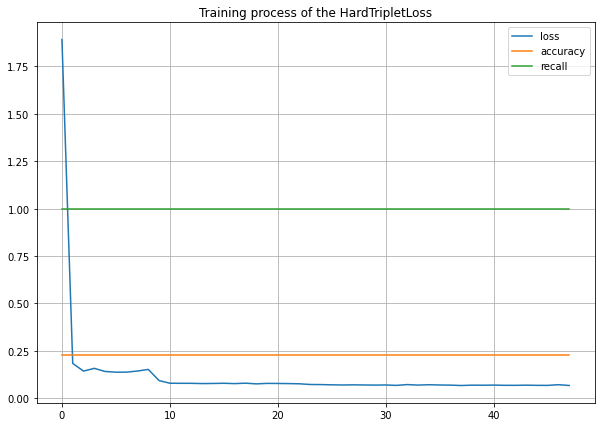

In [102]:
plt.figure(figsize=(10, 7))
plt.title("Training process of the HardTripletLoss")
plt.plot(history.history['loss'], label='loss')
plt.plot(rsc['scores'], label='accuracy')
plt.plot(rsc['recalls'], label='recall')
plt.grid()
plt.legend()

In [98]:
max(rsc['scores'])

0.22954434100930915

![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.meme-arsenal.com%2Fmemes%2Fddb088b3a662269cc7da9a6e2a929eb5.jpg&f=1&nofb=1)

In [99]:
vectorized_X = tfa_model.predict(X_test)

pca = PCA(n_components=3)

pca.fit(vectorized_X)

pca_x = pca.transform(vectorized_X)

y1d = y_test
# y1d = np.argmax(new_y, axis=1)

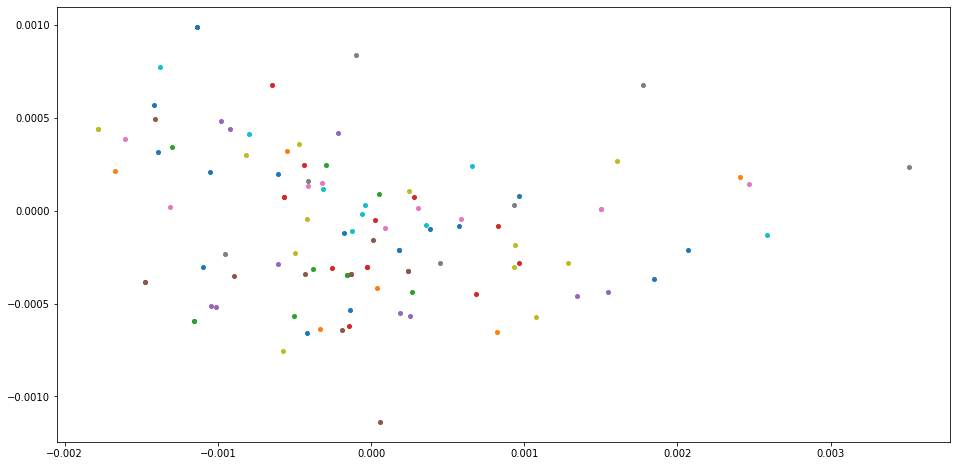

In [101]:
plt.figure(figsize=(16, 8))
for i in range(10):
    plt.plot(pca_x[np.where(y1d==i), 0][0], pca_x[np.where(y1d==i), 1][0], 'o', ms=4)# label=str(i))
# plt.legend(ncol=4)

### Problems of triplet loss
- From [GitHub](https://github.com/omoindrot/tensorflow-triplet-loss/issues/6#issuecomment-385342106)
> However if the loss gets stuck at exactly the margin (0.5), it indicates that all the embeddings are collapsed into a single point. One solution is to reduce the learning rate until training does not collapse.

- I have the same problem, moreover, it was adviced to define batches manually (not all-vs-all)
- One more [notebook](https://datascience-enthusiast.com/DL/Face_Recognition_for_the_Happy_House_v3.html) with triplet loss

## FAT